In [17]:
import os
import numpy as np
import math
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from IPython.display import clear_output
from PIL import Image

import torch
import torch.nn as nn
from torch import autograd
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Dataset, random_split
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torchvision.utils import save_image

In [18]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


class ProgressPlotter:
    def __init__(self) -> None:
        self._history_dict = defaultdict(list)
        self._images = defaultdict(list)

    def add_scalar(self, tag: str, value) -> None:
        self._history_dict[tag].append(value)

    def add_image(self, tag: str, value) -> None:
        self._images[tag].append(value)

    def display_plot(self, title=None) -> None:
        clear_output()
        n_keys = len(self._history_dict)
        fig, ax = plt.subplots(n_keys, 1, figsize=(12, 3 * n_keys))
        for key_idx, key in enumerate(self._history_dict.keys()):
            history_len = len(self._history_dict[key])
            if n_keys == 1:
                ax.plot(self._history_dict[key], color="c", marker="X")
                ax.set_ylabel(key)
                ax.set_xlabel("step")
                if title is not None:
                    ax.set_title(str(title))
            elif n_keys > 1:
                ax[key_idx].plot(self._history_dict[key], color="c", marker="X")
                ax[key_idx].set_ylabel(key)
                ax[key_idx].set_xlabel("step")
                if title is not None:
                    ax[0].set_title(str(title))
        fig.tight_layout()
        plt.show()

    def display_last_image(self, tag: str):
        clear_output()
        if len(self._images[tag]) > 0:
            image = self._images[tag][-1]
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.imshow(image)
            ax.axis("off")
            fig.tight_layout()
            plt.show()
        else:
            print(f"There are no images to show with tag {tag}")

    @property
    def history_dict(self):
        return dict(self._history_dict)

In [19]:
# basic random seed
import os
import random
import numpy as np

DEFAULT_RANDOM_SEED = 42


def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)


# torch random seed
import torch


def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# basic + torch
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)


seedEverything()

In [20]:
#choose the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Dataset was made from KID-F (K-pop Idol Dataset - Female)

In [21]:
#get address such as C:\\(folder with you notebook)
dir = os.path.abspath(os.curdir)
# i suppose what your image folders placed in datasets directory 
data_dir=os.path.join(dir, "images\\")

In [22]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(64, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=(0.9,1.1),saturation=(0.9,1.1),contrast=(0.9,1.1)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize([64,64]),
        transforms.ToTensor()
    ]),
}
 

In [23]:
#Create function to get your(my) images dataset and resize it to size for model
def get_dataset(data_dir, data_transforms ):
    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

In [24]:
trainloader, testloader, classes, dataset_sizes=get_dataset(data_dir,data_transforms)
print('Classes: ',  classes)
print('The datasest have: ',  dataset_sizes ," images")

Classes:  ['asian']
The datasest have:  {'train': 9456, 'test': 2850}  images


In [30]:
# create function for print unnormalized images
def imshow(img):
    #img = img / 2+0.5      # unnormalize
    npimg = img.numpy()
    plt.imshow((np.transpose(npimg, (1, 2, 0))))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images.shape

torch.Size([64, 3, 64, 64])

In [16]:
import torch
from torch import nn

#make a generator with four convolution blocks
class Generator(nn.Module):
    def __init__(self, image_size: int = 64) -> None:
        super().__init__()
        self.image_size = image_size
        self.latent_dim = 16

        self.vec2tensor = nn.Sequential(
            nn.Linear(self.latent_dim, 1024*4*4), nn.LeakyReLU(0.2, inplace=True)
        )

        self.main = nn.Sequential(
            self.upsample_block(1024, 512),  # 4x4->8x8
            self.upsample_block(512, 256),  # 8x8 -> 16x16
            self.upsample_block(256, 128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 3, 3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def upsample_block(self, in_channel, out_channel):
        return nn.Sequential(
            nn.Upsample(scale_factor=2),  # 8x8->16x16
            nn.Conv2d(in_channel, out_channel, 3, stride=1, padding=1),
            nn.InstanceNorm2d(out_channel),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        out = self.vec2tensor(inputs)
        out = self.main(out.reshape(-1, 1024, 4, 4))
        return out

In [11]:
#make function for real/fake image detection
class Discriminator(nn.Module):
    def __init__(self, image_size: int = None) -> None:
        super().__init__()
        # Your code here
        self.image_size = image_size
        self.main = nn.Sequential(
            #nn.AvgPool2d(2),  # 64x64->32x32
            nn.Conv2d(3, 128, 3, stride=2, padding=1),
            nn.Dropout(0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(128),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.Dropout(0.1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(256), 
            nn.Conv2d(256,512, 3, stride=2, padding=1), 
            #nn.AvgPool2d(2),  # 32x32->16x16
            nn.Dropout(0.1),
            nn.LeakyReLU(0.2, inplace=True),    
            nn.InstanceNorm2d(512), 
            nn.Conv2d(512, 1024, 3, stride=2, padding=1), 
            nn.Dropout(0.1),
            nn.LeakyReLU(0.2, inplace=True),    
            nn.InstanceNorm2d(1024), 
            nn.Flatten(),
            nn.Linear(1024*4*4, 1), # in = channel*heght*width
            nn.Sigmoid()
        )

    def forward(self, inputs: torch.Tensor, labels: list = None) -> torch.Tensor:
        # Your code here
        out = self.main(inputs)
        return out  # one number (0..1) per sample

In [12]:
from torchvision.utils import make_grid

#eps=0.001 was chosen so that there are no divisions by zero
#InstanceNorm instead of BatchNorm was chosen for better training
class GANTrainer:
    def __init__(self, generator, discriminator, dataloader):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.discriminator = discriminator.to(self.device)
        self.generator = generator.to(self.device)
        self.dataloader = dataloader
        self.adversarial_criterion = nn.BCELoss()
        self.discriminator_optimizer = torch.optim.Adam(
            discriminator.parameters(), lr=0.0002, betas=(0.0, 0.99),
        )
        self.generator_optimizer = torch.optim.Adam(
            generator.parameters(), lr=0.0002, betas=(0.0, 0.99),)
        self.fixed_noise = torch.randn((10, generator.latent_dim))
        self.pp = ProgressPlotter()
        self.epochs = 50

    def __call__(self):

        for epoch in range(self.epochs):
            self.discriminator.train()
            self.generator.train()

            for i, (inputs, target) in enumerate(self.dataloader):
                batch_size = len(target)
                d_loss = self.train_discriminator(inputs, target)
                g_loss = self.train_generator(batch_size)

                iters = i + epoch * len(self.dataloader) + 1

                print(
                    f"\rEpoch {epoch}/{self.epochs} - {i}/{len(self.dataloader)} - loss_D: {d_loss.item():.4f} - loss_G: {g_loss.item():.4f}",
                    end="",
                )

            self.pp.add_scalar("Train/D_Loss", d_loss.item())
            self.pp.add_scalar("Train/G_Loss", g_loss.item())
            self.display_results()

    def train_discriminator(self, images, target):
        self.discriminator.zero_grad()  # Set discriminator gradients to zero.

        # Train with real.
        real_output = self.discriminator(images.to(self.device))
        batch_size = len(images)
        real_label = self.get_real_labels((batch_size, 1))

        d_loss_real = self.adversarial_criterion(
            real_output, real_label.to(self.device)
        )
        d_loss_real.backward()

        # Train with fake.
        noise = self.get_noise((batch_size, self.generator.latent_dim))
        fake = self.generator(noise.to(self.device))
        fake_output = self.discriminator(fake)

        fake_label = self.get_fake_labels((batch_size, 1))
        d_loss_fake = self.adversarial_criterion(
            fake_output, fake_label.to(self.device)
        )
        d_loss_fake.backward()

        # Count all discriminator losses.
        d_loss = (d_loss_real + d_loss_fake) / 2
        self.discriminator_optimizer.step()
        return d_loss.detach().cpu()

    def train_generator(self, batch_size):
        self.generator.zero_grad()  # Set generator gradients to zero.
        noise = self.get_noise((batch_size, self.generator.latent_dim))

        fake_output = self.generator(noise.to(self.device))
        fake_predictions = self.discriminator(fake_output)

        real_label = self.get_real_labels((batch_size,1))
        g_loss = self.adversarial_criterion(
            fake_predictions, real_label.to(self.device)
        )
        g_loss.backward()
        self.generator_optimizer.step()
        return g_loss.detach().cpu()

    def display_results(self):
        with torch.no_grad():
            self.generator.eval()  # Switch model to eval mode.
            sr = self.generator(self.fixed_noise.to(device))
            img_tensor = sr.cpu().detach()
        clear_output()
        show_samples(img_tensor.permute(0, 2, 3, 1).numpy())
        plt.show()

    # The real sample label for discriminator always is 1,
    def get_real_labels(self, size):
        return torch.ones(size)

    # The fake sample label for discriminator is 0.
    def get_fake_labels(self, size):
        return torch.zeros(size)

    # Get random noise
    def get_noise(self, size):
        return torch.randn(size)


image_size = 64
batch_size = 64



In [13]:
def show_samples(images, titles=[]):
    fig, ax = plt.subplots(nrows=1, ncols=len(images), figsize=(25, 15))
    for i, img in enumerate(images):
        ax[i].imshow(img)
        if len(titles) > i:
            ax[i].set_title(titles[i])
        ax[i].axis("off")
    plt.tight_layout()


In [14]:
netCG = torch.load("CG.pth")
netCD = torch.load("CD.pth")

In [15]:
torch.cuda.empty_cache()

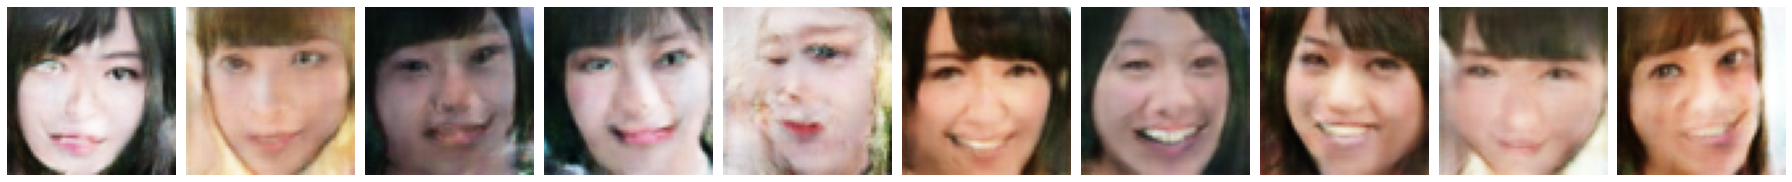

Epoch 17/50 - 156/247 - loss_D: 0.1224 - loss_G: 4.30713

In [ ]:
#netCG = Generator(image_size=image_size)
#netCD = Discriminator(image_size=image_size)

seedEverything()

#Adam optimizer with D:lr=0.0002 G:lr=0.0002 for 100 epochs 
 
trainer = GANTrainer(netCG, netCD, trainloader)
trainer()

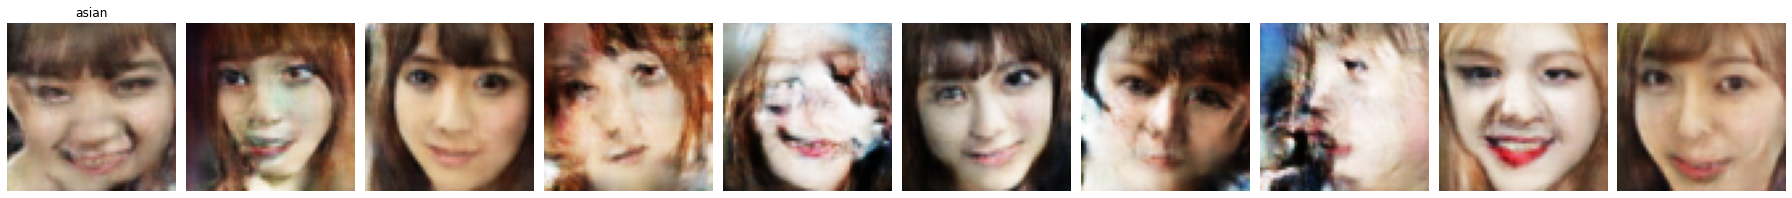

In [18]:
netCG.eval()


generated = netCG(torch.randn((10, 16)).to(device)).cpu().detach().permute(0, 2, 3, 1).numpy()
show_samples(generated,['asian'])

In [19]:
torch.save(netCG, "CG.pth")
torch.save(netCD, "CD.pth")